Лабораторная работа №2. Алгоритм k-ближайших соседей (kNN)

Курс: «Методы принятия решений и машинное обучение»  
Студент: Москвитин М.К., группа 221-321

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_openml


Вспомогательные функции и kNN

In [11]:
# ==========================
# ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ
# ==========================

def generate_synthetic_clusters(n_samples=300,
                                class_centers=None,
                                class_stds=None,
                                class_probs=None,
                                random_state=None):
    """
    Генерация точек в R[0,10] × R[0,100], разделённых на k кластеров.
    Возвращает:
        X: массив формы (n_samples, 2)
        y: массив меток формы (n_samples,)
    """
    if class_centers is None:
        # три кластера: левый нижний угол, центр, правый верхний угол
        class_centers = np.array([
            [2.0, 20.0],  # красные (условно)
            [5.0, 50.0],  # синие
            [8.0, 80.0]  # зелёные
        ])
    else:
        class_centers = np.asarray(class_centers)

    n_classes = class_centers.shape[0]

    if class_stds is None:
        class_stds = [1.0] * n_classes
    class_stds = np.asarray(class_stds)

    if class_probs is None:
        class_probs = np.ones(n_classes) / n_classes
    else:
        class_probs = np.asarray(class_probs, dtype=float)
        class_probs = class_probs / class_probs.sum()

    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)

    # сколько точек попадёт в каждый класс
    counts = rng.multinomial(n_samples, class_probs)

    X_list = []
    y_list = []

    for class_idx, (center, std, count) in enumerate(zip(class_centers,
                                                         class_stds,
                                                         counts)):
        if count == 0:
            continue

        # нормальное распределение вокруг центра
        points = rng.normal(loc=center,
                            scale=std,
                            size=(count, 2))

        # ограничиваем областью R[0,10] × R[0,100]
        points[:, 0] = np.clip(points[:, 0], 0.0, 10.0)
        points[:, 1] = np.clip(points[:, 1], 0.0, 100.0)

        X_list.append(points)
        y_list.append(np.full(shape=(count,),
                              fill_value=class_idx,
                              dtype=int))

    X = np.vstack(X_list)
    y = np.concatenate(y_list)

    return X, y


def scale_data(X_train, X_test):
    """
    Нормировка признаков (StandardScaler).
    Обучаем scaler только на обучающей выборке, потом применяем к train и test.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler


def plot_accuracy_vs_k(k_values, accuracies, title):
    """
    График зависимости точности (accuracy) на тесте от числа соседей k.
    """
    plt.figure(figsize=(6, 4))
    plt.plot(k_values, accuracies, marker="o")
    plt.xlabel("k (число соседей)")
    plt.ylabel("accuracy на тестовой выборке")
    plt.title(title)
    plt.grid(True)
    plt.show()


def plot_train_and_test_predictions(X_train, y_train,
                                    X_test, y_test_pred,
                                    title):
    """
    Визуализация:
      - слева: обучающая выборка (истинные классы)
      - справа: тестовая выборка, окрашенная по предсказанным классам
    """
    unique_classes = np.unique(np.concatenate([y_train, y_test_pred]))
    # палитра для нескольких классов
    colors = ["red", "blue", "green", "orange", "purple", "brown", "pink"]
    color_map = {c: colors[i % len(colors)] for i, c in enumerate(unique_classes)}

    plt.figure(figsize=(10, 4))

    # обучающая выборка
    plt.subplot(1, 2, 1)
    for cls in unique_classes:
        mask = (y_train == cls)
        plt.scatter(X_train[mask, 0],
                    X_train[mask, 1],
                    c=color_map[cls],
                    label=f"класс {cls}",
                    alpha=0.6,
                    edgecolors="k",
                    s=40)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Обучающая выборка (кластеры)")
    plt.grid(True)
    plt.legend()

    # тестовая выборка (предсказания)
    plt.subplot(1, 2, 2)
    for cls in unique_classes:
        mask = (y_test_pred == cls)
        plt.scatter(X_test[mask, 0],
                    X_test[mask, 1],
                    c=color_map[cls],
                    label=f"класс {cls}",
                    alpha=0.6,
                    edgecolors="k",
                    s=40)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Тестовая выборка (предсказанные классы)")
    plt.grid(True)
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def print_confusion_matrix(cm, class_labels=None):
    """
    Красивый вывод матрицы ошибок.
    По соглашению sklearn:
        строки  — истинные классы (y_true)
        столбцы — предсказанные классы (y_pred)
    """
    print("Матрица ошибок (confusion matrix):")
    if class_labels is None:
        class_labels = [str(i) for i in range(cm.shape[0])]

    header = "true\\pred".ljust(10) + " ".join(label.rjust(10) for label in class_labels)
    print(header)
    for i, row in enumerate(cm):
        row_str = class_labels[i].ljust(10) + " ".join(str(x).rjust(10) for x in row)
        print(row_str)
    print()


def plot_diabetes_feature_scatter(X, y, feature_x, feature_y, title):
    """
    Визуализация распределения пациентов по двум признакам.
    Точки окрашены по классу (есть диабет / нет диабета).
    """
    plt.figure(figsize=(6, 5))

    x_vals = X[feature_x].values
    y_vals = X[feature_y].values

    classes = np.unique(y)
    colors = ["blue", "red", "green", "orange"]
    color_map = {cls: colors[i % len(colors)] for i, cls in enumerate(classes)}

    for cls in classes:
        mask = (y == cls)
        plt.scatter(
            x_vals[mask],
            y_vals[mask],
            c=color_map[cls],
            label=str(cls),
            alpha=0.6,
            edgecolors="k",
            s=40,
        )

    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(title)
    plt.grid(True)
    plt.legend(title="Класс")
    plt.tight_layout()
    plt.show()


# ==========================
# АЛГОРИТМ kNN: ПРОСТАЯ РЕАЛИЗАЦИЯ
# ==========================

class KNNClassifier:
    """
    Простая реализация алгоритма k-ближайших соседей (kNN).
    Используем для синтетических данных (классы — целые числа).
    """

    def __init__(self, n_neighbors=5, metric="euclidean"):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        "Обучение" kNN — это просто запоминание обучающей выборки.
        """
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y)

    def _compute_distances(self, X):
        """
        Вычисляем матрицу расстояний между объектами X (тест)
        и объектами обучающей выборки X_train.

        Возвращает массив shape (n_test, n_train).
        """
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(1, -1)

        if self.metric == "euclidean":
            # Евклидово расстояние
            diff = X[:, np.newaxis, :] - self.X_train[np.newaxis, :, :]
            dists = np.sqrt(np.sum(diff ** 2, axis=2))
        elif self.metric == "manhattan":
            # Манхэттенское расстояние
            diff = np.abs(X[:, np.newaxis, :] - self.X_train[np.newaxis, :, :])
            dists = np.sum(diff, axis=2)
        else:
            raise ValueError(f"Неизвестная метрика расстояния: {self.metric}")

        return dists

    def predict(self, X):
        """
        Предсказание классов для объектов X.
        Для каждого объекта:
          1) считаем расстояния до всех точек обучающей выборки
          2) находим k ближайших соседей
          3) голосуем по меткам этих соседей
        """
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(1, -1)

        dists = self._compute_distances(X)
        n_test = X.shape[0]
        y_pred = np.zeros(n_test, dtype=int)

        for i in range(n_test):
            # индексы k ближайших соседей
            neighbor_idx = np.argsort(dists[i])[: self.n_neighbors]
            neighbor_labels = self.y_train[neighbor_idx]

            # считаем, сколько раз встречается каждый класс
            values, counts = np.unique(neighbor_labels, return_counts=True)
            max_count = counts.max()
            candidates = values[counts == max_count]

            # при ничьей берём класс с минимальным номером
            y_pred[i] = candidates.min()

        return y_pred


## Часть 1. Синтетические данные (кластеры в R[0,10] × R[0,100])

Генерируются искусственные данные — несколько кластеров в прямоугольнике 
R[0,10] × R[0,100]. Для них используется собственная реализация kNN и 
проводятся эксперименты с:
- различной степенью пересечения кластеров,
- наличием/отсутствием нормализации,
- различным количеством соседей k,
- диспропорцией классов.

Для каждого сценария считаются:
- accuracy на тестовой выборке,
- матрица ошибок,
- строятся графики accuracy(k) и визуализация кластеров.

In [12]:
# ==========================
# ЧАСТЬ 1. СИНТЕТИЧЕСКИЕ ДАННЫЕ
# ==========================

def run_synthetic_experiments():
    """
    Часть 1 лабораторной:
    - генерируем точки в R[0,10] × R[0,100], разделённые на кластеры
    - реализуем kNN для новых 0.1 * N точек
    - считаем accuracy и confusion matrix
    - показываем работу алгоритма графически
    - экспериментируем с:
        * наличием и отсутствием нормализации
        * степенью пересечения кластеров
        * количеством соседей k
        * диспропорцией классов
    """
    print("=== ЧАСТЬ 1. СИНТЕТИЧЕСКИЕ ДАННЫЕ (kNN) ===", end='\n\n')

    # N точек в обучающей выборке
    n_train = 500
    # новые 0.1 * N точек для теста
    n_test = int(0.1 * n_train)

    # три кластера по условию: левый нижний угол, центр, правый верхний
    base_centers = np.array([
        [2.0, 18.0],
        [4.0, 25.0],
        [6.0, 32.0]
    ])

    experiments = [
        {
            "name": "Малое пересечение кластеров, сбалансированные классы, без нормализации",
            "class_stds": [1.7, 1.7, 1.7],
            "class_probs": [1 / 3, 1 / 3, 1 / 3],
            "use_scaling": False
        },
        {
            "name": "Сильное пересечение кластеров, сбалансированные классы, с нормализацией",
            "class_stds": [3.5, 3.5, 3.5],
            "class_probs": [1 / 3, 1 / 3, 1 / 3],
            "use_scaling": True
        },
        {
            "name": "Диспропорция классов (0.6, 0.3, 0.1), с нормализацией",
            "class_stds": [2.0, 2.0, 2.0],
            "class_probs": [0.6, 0.3, 0.1],
            "use_scaling": True
        }
    ]

    # список k, по которым будем строить графики и подбирать оптимальное значение
    k_values = [1, 3, 5, 7, 9, 11, 15, 21]

    for exp_idx, exp in enumerate(experiments, start=1):
        print(f"--- Эксперимент {exp_idx}: {exp['name']} ---", end='\n\n')

        X_train, y_train = generate_synthetic_clusters(
            n_samples=n_train,
            class_centers=base_centers,
            class_stds=exp["class_stds"],
            class_probs=exp["class_probs"],
            random_state=42 + exp_idx
        )

        X_test, y_test = generate_synthetic_clusters(
            n_samples=n_test,
            class_centers=base_centers,
            class_stds=exp["class_stds"],
            class_probs=exp["class_probs"],
            random_state=100 + exp_idx
        )

        print("Форма обучающей выборки X_train:", X_train.shape)
        print("Форма обучающих меток y_train:", y_train.shape)
        print("Форма тестовой выборки X_test:", X_test.shape)
        print("Форма истинных меток y_test:", y_test.shape, end='\n\n')

        # небольшая статистика по классам
        unique_classes, counts_train = np.unique(y_train, return_counts=True)
        _, counts_test = np.unique(y_test, return_counts=True)
        print("Распределение классов (train / test):")
        for cls, c_tr, c_te in zip(unique_classes, counts_train, counts_test):
            print(f"  класс {cls}: train = {c_tr}, test = {c_te}")
        print()

        if exp["use_scaling"]:
            X_train_used, X_test_used, _ = scale_data(X_train, X_test)
            print("Признаки нормированы (StandardScaler).")
            # Проверка, что нормировка реально что-то меняет
            print("Пример X_train ДО нормировки:\n", X_train[:3])
            print("Пример X_train ПОСЛЕ нормировки:\n", X_train_used[:3], "\n")
        else:
            X_train_used, X_test_used = X_train, X_test
            print("Признаки НЕ нормировались.")
            # Проверка, что мы действительно используем исходные данные
            print("Проверка: X_train_used совпадает с X_train:",
                  np.allclose(X_train_used, X_train), "\n")

        accuracies = []

        for k in k_values:
            knn = KNNClassifier(n_neighbors=k, metric="euclidean")
            knn.fit(X_train_used, y_train)
            y_pred = knn.predict(X_test_used)
            acc = accuracy_score(y_test, y_pred)
            accuracies.append(acc)
            print(f"k = {k:2d}: accuracy = {acc:.4f}")

        print()

        # выбираем k с максимальной точностью
        best_idx = int(np.argmax(accuracies))
        best_k = k_values[best_idx]
        best_acc = accuracies[best_idx]
        print(f"Лучшее k для этого эксперимента: k = {best_k}, accuracy = {best_acc:.4f}", end='\n\n')

        # пересчитываем предсказания для выбранного k
        knn_best = KNNClassifier(n_neighbors=best_k, metric="euclidean")
        knn_best.fit(X_train_used, y_train)
        y_pred_best = knn_best.predict(X_test_used)

        # матрица ошибок и точность
        cm = confusion_matrix(y_test, y_pred_best, labels=np.unique(y_train))
        print("Строки — истинные классы, столбцы — предсказанные классы.")
        print_confusion_matrix(cm, class_labels=[str(c) for c in np.unique(y_train)])

        # график accuracy(k)
        plot_accuracy_vs_k(
            k_values,
            accuracies,
            title=f"Accuracy на тесте в зависимости от k\n{exp['name']}"
        )

        # визуализация раскрашенных точек обучающей и тестовой выборки
        plot_train_and_test_predictions(
            X_train,
            y_train,
            X_test,
            y_pred_best,
            title=f"Синтетические данные: {exp['name']} (k = {best_k})"
        )


=== ЧАСТЬ 1. СИНТЕТИЧЕСКИЕ ДАННЫЕ (kNN) ===

--- Эксперимент 1: Малое пересечение кластеров, сбалансированные классы, без нормализации ---

Форма обучающей выборки X_train: (500, 2)
Форма обучающих меток y_train: (500,)
Форма тестовой выборки X_test: (50, 2)
Форма истинных меток y_test: (50,)

Распределение классов (train / test):
  класс 0: train = 158, test = 17
  класс 1: train = 171, test = 17
  класс 2: train = 171, test = 16

Признаки НЕ нормировались.
Проверка: X_train_used совпадает с X_train: True 

k =  1: accuracy = 0.9000
k =  3: accuracy = 0.9400
k =  5: accuracy = 0.9600
k =  7: accuracy = 0.9600
k =  9: accuracy = 0.9600
k = 11: accuracy = 0.9600
k = 15: accuracy = 0.9400
k = 21: accuracy = 0.9600

Лучшее k для этого эксперимента: k = 5, accuracy = 0.9600

Строки — истинные классы, столбцы — предсказанные классы.
Матрица ошибок (confusion matrix):
true\pred          0          1          2
0                 17          0          0
1                  0         15        

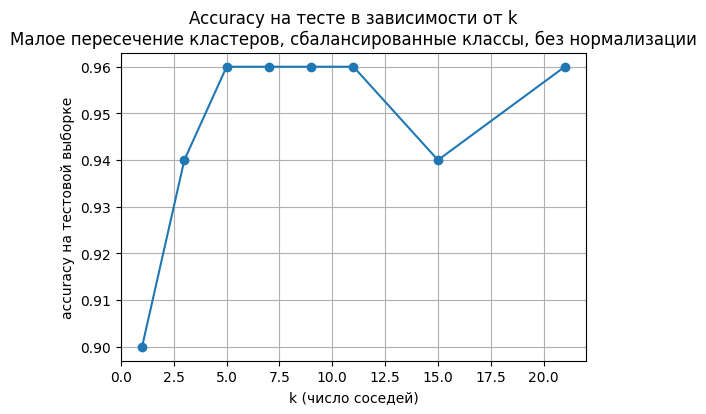

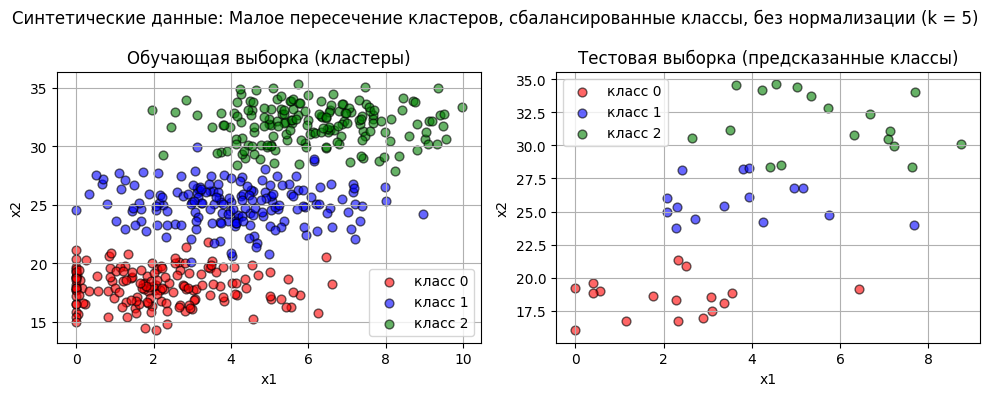

--- Эксперимент 2: Сильное пересечение кластеров, сбалансированные классы, с нормализацией ---

Форма обучающей выборки X_train: (500, 2)
Форма обучающих меток y_train: (500,)
Форма тестовой выборки X_test: (50, 2)
Форма истинных меток y_test: (50,)

Распределение классов (train / test):
  класс 0: train = 176, test = 17
  класс 1: train = 160, test = 18
  класс 2: train = 164, test = 15

Признаки нормированы (StandardScaler).
Пример X_train ДО нормировки:
 [[ 6.3614901  12.38279491]
 [ 0.         11.9972534 ]
 [ 8.50574292 18.30655792]]
Пример X_train ПОСЛЕ нормировки:
 [[ 0.69901559 -1.82566371]
 [-1.35943332 -1.88287632]
 [ 1.39285222 -0.94660422]] 

k =  1: accuracy = 0.7400
k =  3: accuracy = 0.8600
k =  5: accuracy = 0.8200
k =  7: accuracy = 0.8200
k =  9: accuracy = 0.8600
k = 11: accuracy = 0.8600
k = 15: accuracy = 0.8400
k = 21: accuracy = 0.8400

Лучшее k для этого эксперимента: k = 3, accuracy = 0.8600

Строки — истинные классы, столбцы — предсказанные классы.
Матрица ошиб

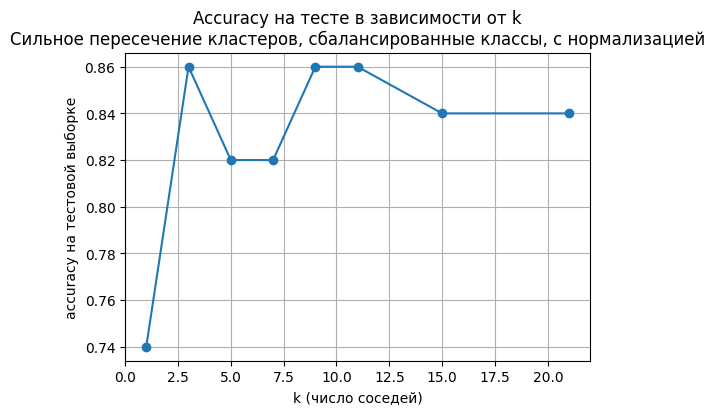

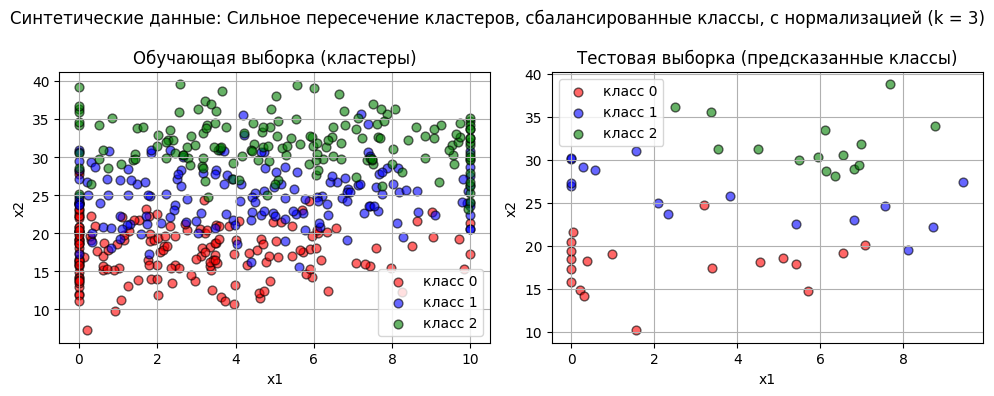

--- Эксперимент 3: Диспропорция классов (0.6, 0.3, 0.1), с нормализацией ---

Форма обучающей выборки X_train: (500, 2)
Форма обучающих меток y_train: (500,)
Форма тестовой выборки X_test: (50, 2)
Форма истинных меток y_test: (50,)

Распределение классов (train / test):
  класс 0: train = 292, test = 31
  класс 1: train = 151, test = 16
  класс 2: train = 57, test = 3

Признаки нормированы (StandardScaler).
Пример X_train ДО нормировки:
 [[ 2.57936182 16.25339071]
 [ 2.78814531 19.87021109]
 [ 1.96863058 18.51919193]]
Пример X_train ПОСЛЕ нормировки:
 [[-0.25825143 -1.04269354]
 [-0.16694259 -0.33534586]
 [-0.52534709 -0.59956697]] 

k =  1: accuracy = 0.9200
k =  3: accuracy = 0.9800
k =  5: accuracy = 0.9800
k =  7: accuracy = 0.9800
k =  9: accuracy = 0.9800
k = 11: accuracy = 1.0000
k = 15: accuracy = 1.0000
k = 21: accuracy = 1.0000

Лучшее k для этого эксперимента: k = 11, accuracy = 1.0000

Строки — истинные классы, столбцы — предсказанные классы.
Матрица ошибок (confusion matri

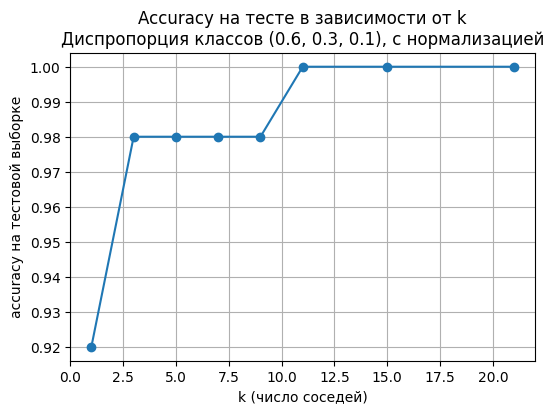

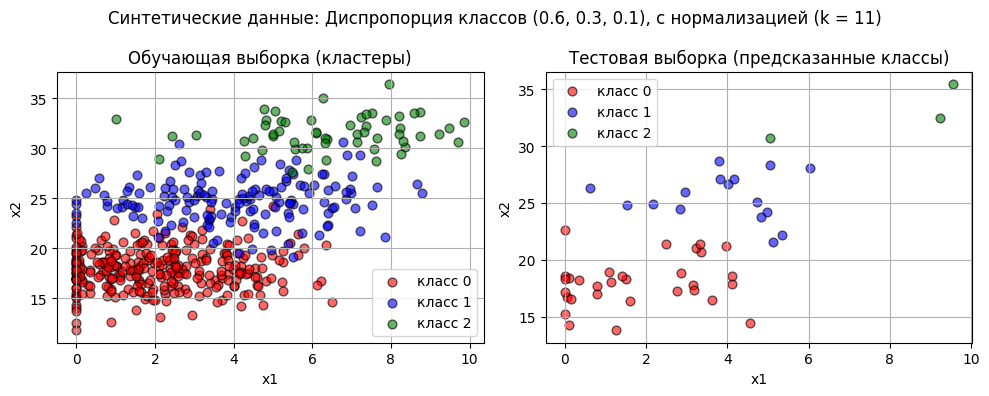

In [13]:
# Запуск ЧАСТИ 1 (синтетические данные)
np.random.seed(42)  # фиксируем seed для воспроизводимости
run_synthetic_experiments()


## Часть 2. Реальный датасет (диабет)

Используется реальный датасет по диабету (Pima Indians Diabetes) из OpenML.  
Выполняются:

- загрузка и первичное описание данных;
- обработка пропусков (нули как псевдопропуски → замена на медиану);
- визуализация распределения пациентов по двум признакам;
- разбиение на обучающую и тестовую выборки;
- нормировка признаков (StandardScaler);
- перебор значений k для kNN и выбор лучшего;
- расчёт accuracy и матрицы ошибок на тестовой выборке.

In [14]:
# ==========================
# ЧАСТЬ 2. РЕАЛЬНЫЙ ДАТАСЕТ (ДИАБЕТ)
# ==========================

def load_and_preprocess_diabetes(test_size=0.2, random_state=42):
    """
    Часть 2, вариант 1:
      - загрузка датасета по диабету (Pima Indians Diabetes из OpenML)
      - описание датасета
      - обработка "пропусков" (нулевые значения в признаках)
      - нормировка признаков
      - разбиение на train/test
    Возвращает:
        X_train_scaled, X_test_scaled, y_train, y_test, feature_names
    """
    print("Загружаем датасет по диабету из OpenML (Pima Indians Diabetes)...", end='\n\n')

    diabetes = fetch_openml(name="diabetes", version=1, as_frame=True)
    X = diabetes.data
    y = diabetes.target

    print("Размерность признаков X (объекты × признаки):", X.shape)
    print("Размерность целевого вектора y:", y.shape, end='\n\n')

    print("Первые строки X:")
    print(X.head(), end='\n\n')

    print("Типы признаков (все числовые — количественные):")
    print(X.dtypes, end='\n\n')

    print("Тип целевой переменной (классы):", y.dtype)
    print("Распределение целевого класса:")
    print(y.value_counts(), end='\n\n')

    # Проверка явных пропусков (NaN)
    n_missing = X.isna().sum().sum()
    print("Количество явных пропусков (NaN) в признаках:", n_missing)

    # В этом датасете пропуски часто закодированы нулями — считаем количество нулей
    print("Количество нулевых значений по каждому признаку (будем считать их пропусками):")
    print((X == 0).sum(), end='\n\n')

    # Замена нулей на медиану по столбцу (по условию: среднее / мода / медиана — берём медиану)
    X_imputed = X.copy()
    numeric_columns = X_imputed.select_dtypes(include=[np.number]).columns

    for col in numeric_columns:
        zero_mask = X_imputed[col] == 0
        if zero_mask.any():
            median_value = X_imputed.loc[~zero_mask, col].median()
            X_imputed.loc[zero_mask, col] = median_value

    print("После замены нулей (пропусков) медианой:")
    print((X_imputed == 0).sum(), end='\n\n')

    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    # -----------------------------
    # Визуализация распределения пациентов по двум признакам
    # -----------------------------

    # Попробуем взять осмысленные признаки, если они есть в данных
    # В классическом наборе Pima Indians Diabetes это 'plas' (глюкоза) и 'mass' (BMI)
    feature_x = 'plas' if 'plas' in X_imputed.columns else X_imputed.columns[0]
    feature_y = 'mass' if 'mass' in X_imputed.columns else X_imputed.columns[1]

    print(f"Для визуализации используем признаки: {feature_x} и {feature_y}\n")

    plot_diabetes_feature_scatter(
        X_imputed,
        y,
        feature_x=feature_x,
        feature_y=feature_y,
        title=f'Диабет: распределение по признакам {feature_x} и {feature_y}'
    )

    print("Размер обучающей выборки X_train:", X_train.shape)
    print("Размер тестовой выборки X_test:", X_test.shape, end='\n\n')

    print("Распределение классов в обучающей выборке:")
    print(y_train.value_counts(), end='\n\n')

    print("Распределение классов в тестовой выборке:")
    print(y_test.value_counts(), end='\n\n')

    # Нормировка признаков (StandardScaler), отдельно по train и test
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    feature_names = list(X_imputed.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test, feature_names


def run_diabetes_experiment():
    """
    Часть 2 лабораторной (вариант 1, диабет):
      - предобработка данных
      - подбор k
      - оценка accuracy и confusion matrix
    """
    print("=== ЧАСТЬ 2. РЕАЛЬНЫЙ ДАТАСЕТ (ДИАБЕТ) ===", end='\n\n')

    X_train_scaled, X_test_scaled, y_train, y_test, feature_names = load_and_preprocess_diabetes()

    # Подбор k: перебор нечётных значений от 1 до 31
    k_values = list(range(1, 32, 2))
    accuracies = []

    for k in k_values:
        model = KNeighborsClassifier(
            n_neighbors=k,
            metric="minkowski",  # по умолчанию p=2 — Евклидово расстояние
            p=2
        )
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        print(f"k = {k:2d}: accuracy = {acc:.4f}")

    print()

    # выбираем k с максимальной точностью
    best_idx = int(np.argmax(accuracies))
    best_k = k_values[best_idx]
    best_acc = accuracies[best_idx]

    print(f"Лучшее k для диабетического датасета: k = {best_k}, accuracy = {best_acc:.4f}", end='\n\n')

    # Обучаем окончательную модель с лучшим k и оцениваем качество
    best_model = KNeighborsClassifier(
        n_neighbors=best_k,
        metric="minkowski",
        p=2
    )
    best_model.fit(X_train_scaled, y_train)
    y_test_pred = best_model.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_test_pred, labels=np.unique(y_train))

    print("Строки — истинные классы, столбцы — предсказанные классы.")
    print_confusion_matrix(cm, class_labels=list(np.unique(y_train)))

    # График accuracy(k)
    plot_accuracy_vs_k(
        k_values,
        accuracies,
        title="Диабет: accuracy на тестовой выборке в зависимости от k"
    )


=== ЧАСТЬ 2. РЕАЛЬНЫЙ ДАТАСЕТ (ДИАБЕТ) ===

Загружаем датасет по диабету из OpenML (Pima Indians Diabetes)...

Размерность признаков X (объекты × признаки): (768, 8)
Размерность целевого вектора y: (768,)

Первые строки X:
   preg  plas  pres  skin  insu  mass   pedi  age
0     6   148    72    35     0  33.6  0.627   50
1     1    85    66    29     0  26.6  0.351   31
2     8   183    64     0     0  23.3  0.672   32
3     1    89    66    23    94  28.1  0.167   21
4     0   137    40    35   168  43.1  2.288   33

Типы признаков (все числовые — количественные):
preg      int64
plas      int64
pres      int64
skin      int64
insu      int64
mass    float64
pedi    float64
age       int64
dtype: object

Тип целевой переменной (классы): category
Распределение целевого класса:
class
tested_negative    500
tested_positive    268
Name: count, dtype: int64

Количество явных пропусков (NaN) в признаках: 0
Количество нулевых значений по каждому признаку (будем считать их пропусками):
preg  

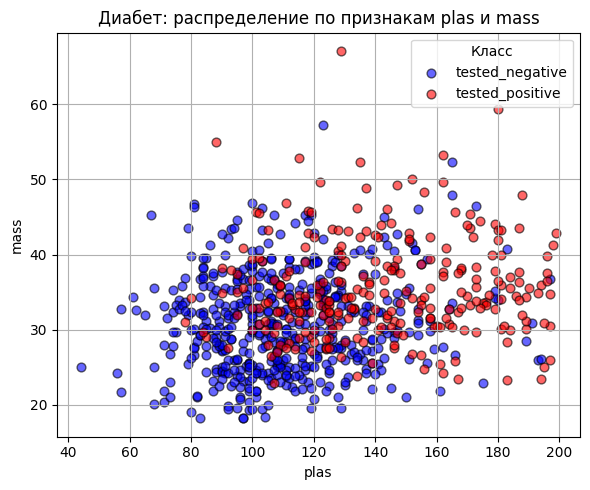

Размер обучающей выборки X_train: (614, 8)
Размер тестовой выборки X_test: (154, 8)

Распределение классов в обучающей выборке:
class
tested_negative    400
tested_positive    214
Name: count, dtype: int64

Распределение классов в тестовой выборке:
class
tested_negative    100
tested_positive     54
Name: count, dtype: int64

k =  1: accuracy = 0.7143
k =  3: accuracy = 0.7662
k =  5: accuracy = 0.7468
k =  7: accuracy = 0.7468
k =  9: accuracy = 0.7597
k = 11: accuracy = 0.7273
k = 13: accuracy = 0.7208
k = 15: accuracy = 0.7468
k = 17: accuracy = 0.7273
k = 19: accuracy = 0.7338
k = 21: accuracy = 0.7532
k = 23: accuracy = 0.7532
k = 25: accuracy = 0.7597
k = 27: accuracy = 0.7338
k = 29: accuracy = 0.7468
k = 31: accuracy = 0.7532

Лучшее k для диабетического датасета: k = 3, accuracy = 0.7662

Строки — истинные классы, столбцы — предсказанные классы.
Матрица ошибок (confusion matrix):
true\pred tested_negative tested_positive
tested_negative        81         19
tested_positive    

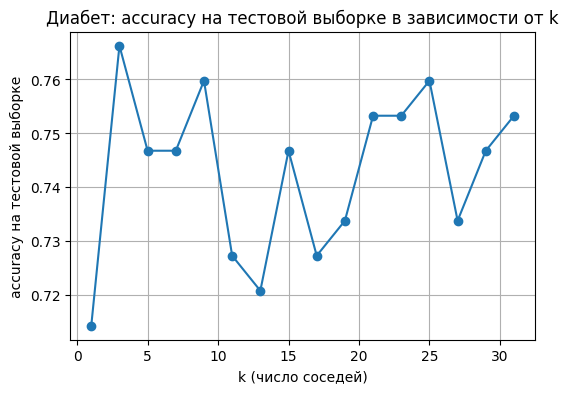

In [15]:
# Запуск ЧАСТИ 2 (реальный датасет диабета)
run_diabetes_experiment()


1. Что такое алгоритм k-ближайших соседей?
Алгоритм k-ближайших соседей (k-Nearest Neighbors, kNN) — это простой
метод машинного обучения "по образцу". Он не строит явную модель, а
просто запоминает обучающую выборку.
Чтобы классифицировать новый объект, алгоритм:
    1) измеряет расстояние от этого объекта до всех объектов обучающей выборки;
    2) выбирает k объектов, которые находятся ближе всего (k ближайших соседей);
    3) смотрит, какие классы у этих соседей, и выбирает итоговый класс по
       какому-то правилу (обычно — по большинству голосов).
Главная идея: похожие объекты (по признакам) должны иметь похожие
целевые значения (классы).


2. Как выбирается класс объекта в алгоритме kNN?
Класс нового объекта выбирается на основе классов его k ближайших соседей:
    1) для нового объекта считаются расстояния до всех объектов обучающей выборки;
    2) выбираются k объектов с минимальным расстоянием;
    3) по классам этих соседей проводится "голосование":
        - считаем, сколько раз встречается каждый класс среди соседей;
        - выбираем класс, который встречается чаще всего (большинство голосов).
Если есть несколько классов с одинаковым числом голосов, можно:
    - выбрать класс с меньшим индексом;
    - или использовать более сложные правила (например, взвесить голоса
      по расстоянию — ближние соседи получают больший вес).
В приведённой реализации для синтетики при ничьей берётся класс с
минимальным номером.


3. Как влияет количество соседей на работу алгоритма?
Число соседей k — основной гиперпараметр kNN и сильно влияет на поведение
алгоритма:
    - Малое k (например, k = 1):
        * модель очень чувствительна к шуму;
        * один "шумный" объект может сильно исказить предсказание;
        * возможен сильный overfitting (переобучение).
    - Большое k:
        * модель становится более сглаженной и устойчивой к шуму;
        * каждый объект классифицируется по "мнению" большого числа соседей;
        * возможно underfitting (недообучение), когда границы классов становятся
          слишком "грубыми" и модель плохо различает классы.
Обычно k подбирают экспериментально (по качеству на валидационной/тестовой
выборке), перебирая диапазон значений и выбирая то k, при котором метрика
качества (например, accuracy) максимальна.


4. Какие метрики расстояния могут быть использованы в алгоритме kNN?
В kNN можно использовать любую разумную метрику расстояния между объектами.
Наиболее популярные:
    - Евклидово расстояние (L2):
        d(x, z) = sqrt( Σ_i (x_i - z_i)^2 )
        Это "обычное" геометрическое расстояние в пространстве признаков.
    - Манхэттенское расстояние (L1):
        d(x, z) = Σ_i |x_i - z_i|
        Используется, когда важен суммарный модуль разности по признакам.
    - Минковского (обобщение L1 и L2):
        d(x, z) = ( Σ_i |x_i - z_i|^p )^(1/p)
        При p=2 получаем Евклидово расстояние, при p=1 — Манхэттенское.
    - Косинусное расстояние (на основе косинусного сходства)
        — удобно, когда важен угол между векторами (направление), а не их длина.
    - Другие специальные метрики для категориальных, текстовых и др. данных.
В sklearn по умолчанию используется метрика Minkowski с p=2 (то есть
Евклидово расстояние). В собственной реализации в этой работе показаны
Евклидово и Манхэттенское расстояния.


5. Какие есть выборки и для каких целей они служат?
В задачах машинного обучения обычно выделяют несколько типов выборок:

    1) Обучающая выборка (training set)
       - На ней модель "учится": подбирает параметры (веса) или,
         как в kNN, просто запоминает примеры.
       - Алгоритм видит истинные ответы (метки классов) и использует
         их для настройки.

    2) Валидационная выборка (validation set)
       - Используется для подбора гиперпараметров (например, выбор k
         в алгоритме kNN, выбор метрики расстояния и т.д.).
       - Модель на ней не обучается, а только проверяется.
       - Помогает избежать переобучения при выборе настроек.

    3) Тестовая выборка (test set)
       - Используется только для финальной оценки качества модели.
       - Модель и гиперпараметры к этому моменту уже зафиксированы.
       - На тестовой выборке оценивают, насколько хорошо модель будет
         работать на новых, ранее не виденных данных.

Иногда дополнительно выделяют:
    - тренировочную часть внутри train (для обучения)
    - и валидационную часть (для подбора параметров),
      либо используют кросс-валидацию.
В этой лабораторной работе:
    - в части 1 (синтетические данные) основное разделение — на обучающие
      точки и новые тестовые точки;
    - в части 2 (диабет) данные делятся на тренировочную и тестовую выборки,
      а k подбирается по качеству на тесте из заданного диапазона.